# Predicting Housing Prices with Ordinary Least Squares

In [43]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import math
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

- We load the data from the PostgreSQL database and print out some observations:

In [21]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

## Data Exploration and Cleaning 

In [3]:
housing_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [45]:
housing_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,...,753.000000,753.000000,753.000000,753.000000,753.000000,753.0,753.000000,753.000000,753.000000,753.000000
mean,729.464807,53.625498,67.390438,9017.219124,6.160691,5.494024,1975.808765,1986.661355,87.208499,401.318725,...,86.764940,41.335989,15.463479,0.030544,5.431607,0.0,3.790173,6.233732,2007.784861,175449.679947
std,424.144015,40.263467,20.165776,3367.500916,1.312560,0.967712,29.600587,21.169926,135.804176,404.034990,...,104.580312,49.441186,43.577536,0.838167,26.551454,0.0,38.455882,2.658003,1.354242,63972.859583
min,1.000000,20.000000,21.000000,1300.000000,2.000000,3.000000,1890.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,2006.000000,35311.000000
25%,374.000000,20.000000,58.000000,7200.000000,5.000000,5.000000,1954.000000,1968.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.000000,2007.000000,129000.000000
50%,724.000000,50.000000,68.000000,9000.000000,6.000000,5.000000,1979.000000,1997.000000,0.000000,364.000000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.0,0.000000,6.000000,2008.000000,163000.000000
75%,1100.000000,60.000000,80.000000,10762.000000,7.000000,6.000000,2004.000000,2005.000000,148.000000,686.000000,...,168.000000,64.000000,0.000000,0.000000,0.000000,0.0,0.000000,8.000000,2009.000000,212000.000000
max,1457.000000,180.000000,140.000000,22420.000000,10.000000,8.000000,2009.000000,2010.000000,650.000000,1572.000000,...,431.000000,214.000000,194.000000,23.000000,170.000000,0.0,400.000000,12.000000,2010.000000,377500.000000


In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

- Some columns that are numerical and some are non-numerical. It is an important difference, if we would like to use categorical data in the regression model, the categorical data will first have to be converted to numerical values.

In [6]:
non_numeric_columns = housing_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [7]:
numeric_columns = housing_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [8]:
total_missing = housing_df.isnull().sum().sort_values(ascending=False)

percent_missing = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


- 19 of the features have missing values. The missing data of type int or float can be handled by interpolation.

In [9]:
missing_data_df = housing_df[['poolqc','miscfeature','alley','fence','fireplacequ','lotfrontage','garagecond','garagetype','garageyrblt',
            'garagefinish','garagequal','bsmtexposure','bsmtfintype2','bsmtfintype1','bsmtcond','bsmtcond','bsmtqual',
            'masvnrarea','masvnrtype','electrical']]
missing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 20 columns):
poolqc          7 non-null object
miscfeature     54 non-null object
alley           91 non-null object
fence           281 non-null object
fireplacequ     770 non-null object
lotfrontage     1201 non-null float64
garagecond      1379 non-null object
garagetype      1379 non-null object
garageyrblt     1379 non-null float64
garagefinish    1379 non-null object
garagequal      1379 non-null object
bsmtexposure    1422 non-null object
bsmtfintype2    1422 non-null object
bsmtfintype1    1423 non-null object
bsmtcond        1423 non-null object
bsmtcond        1423 non-null object
bsmtqual        1423 non-null object
masvnrarea      1452 non-null float64
masvnrtype      1452 non-null object
electrical      1459 non-null object
dtypes: float64(3), object(17)
memory usage: 228.2+ KB


In [10]:
fill_list = ['lotfrontage','garageyrblt','masvnrarea']

for col in housing_df:
    housing_df.loc[:, col].interpolate(inplace=True)    

In [11]:
total_missing = housing_df.isnull().sum().sort_values(ascending=False)

percent_missing = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data.head(16)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
garagetype,81,0.055479
garagecond,81,0.055479
garagefinish,81,0.055479
garagequal,81,0.055479
bsmtexposure,38,0.026027


<Figure size 432x288 with 0 Axes>

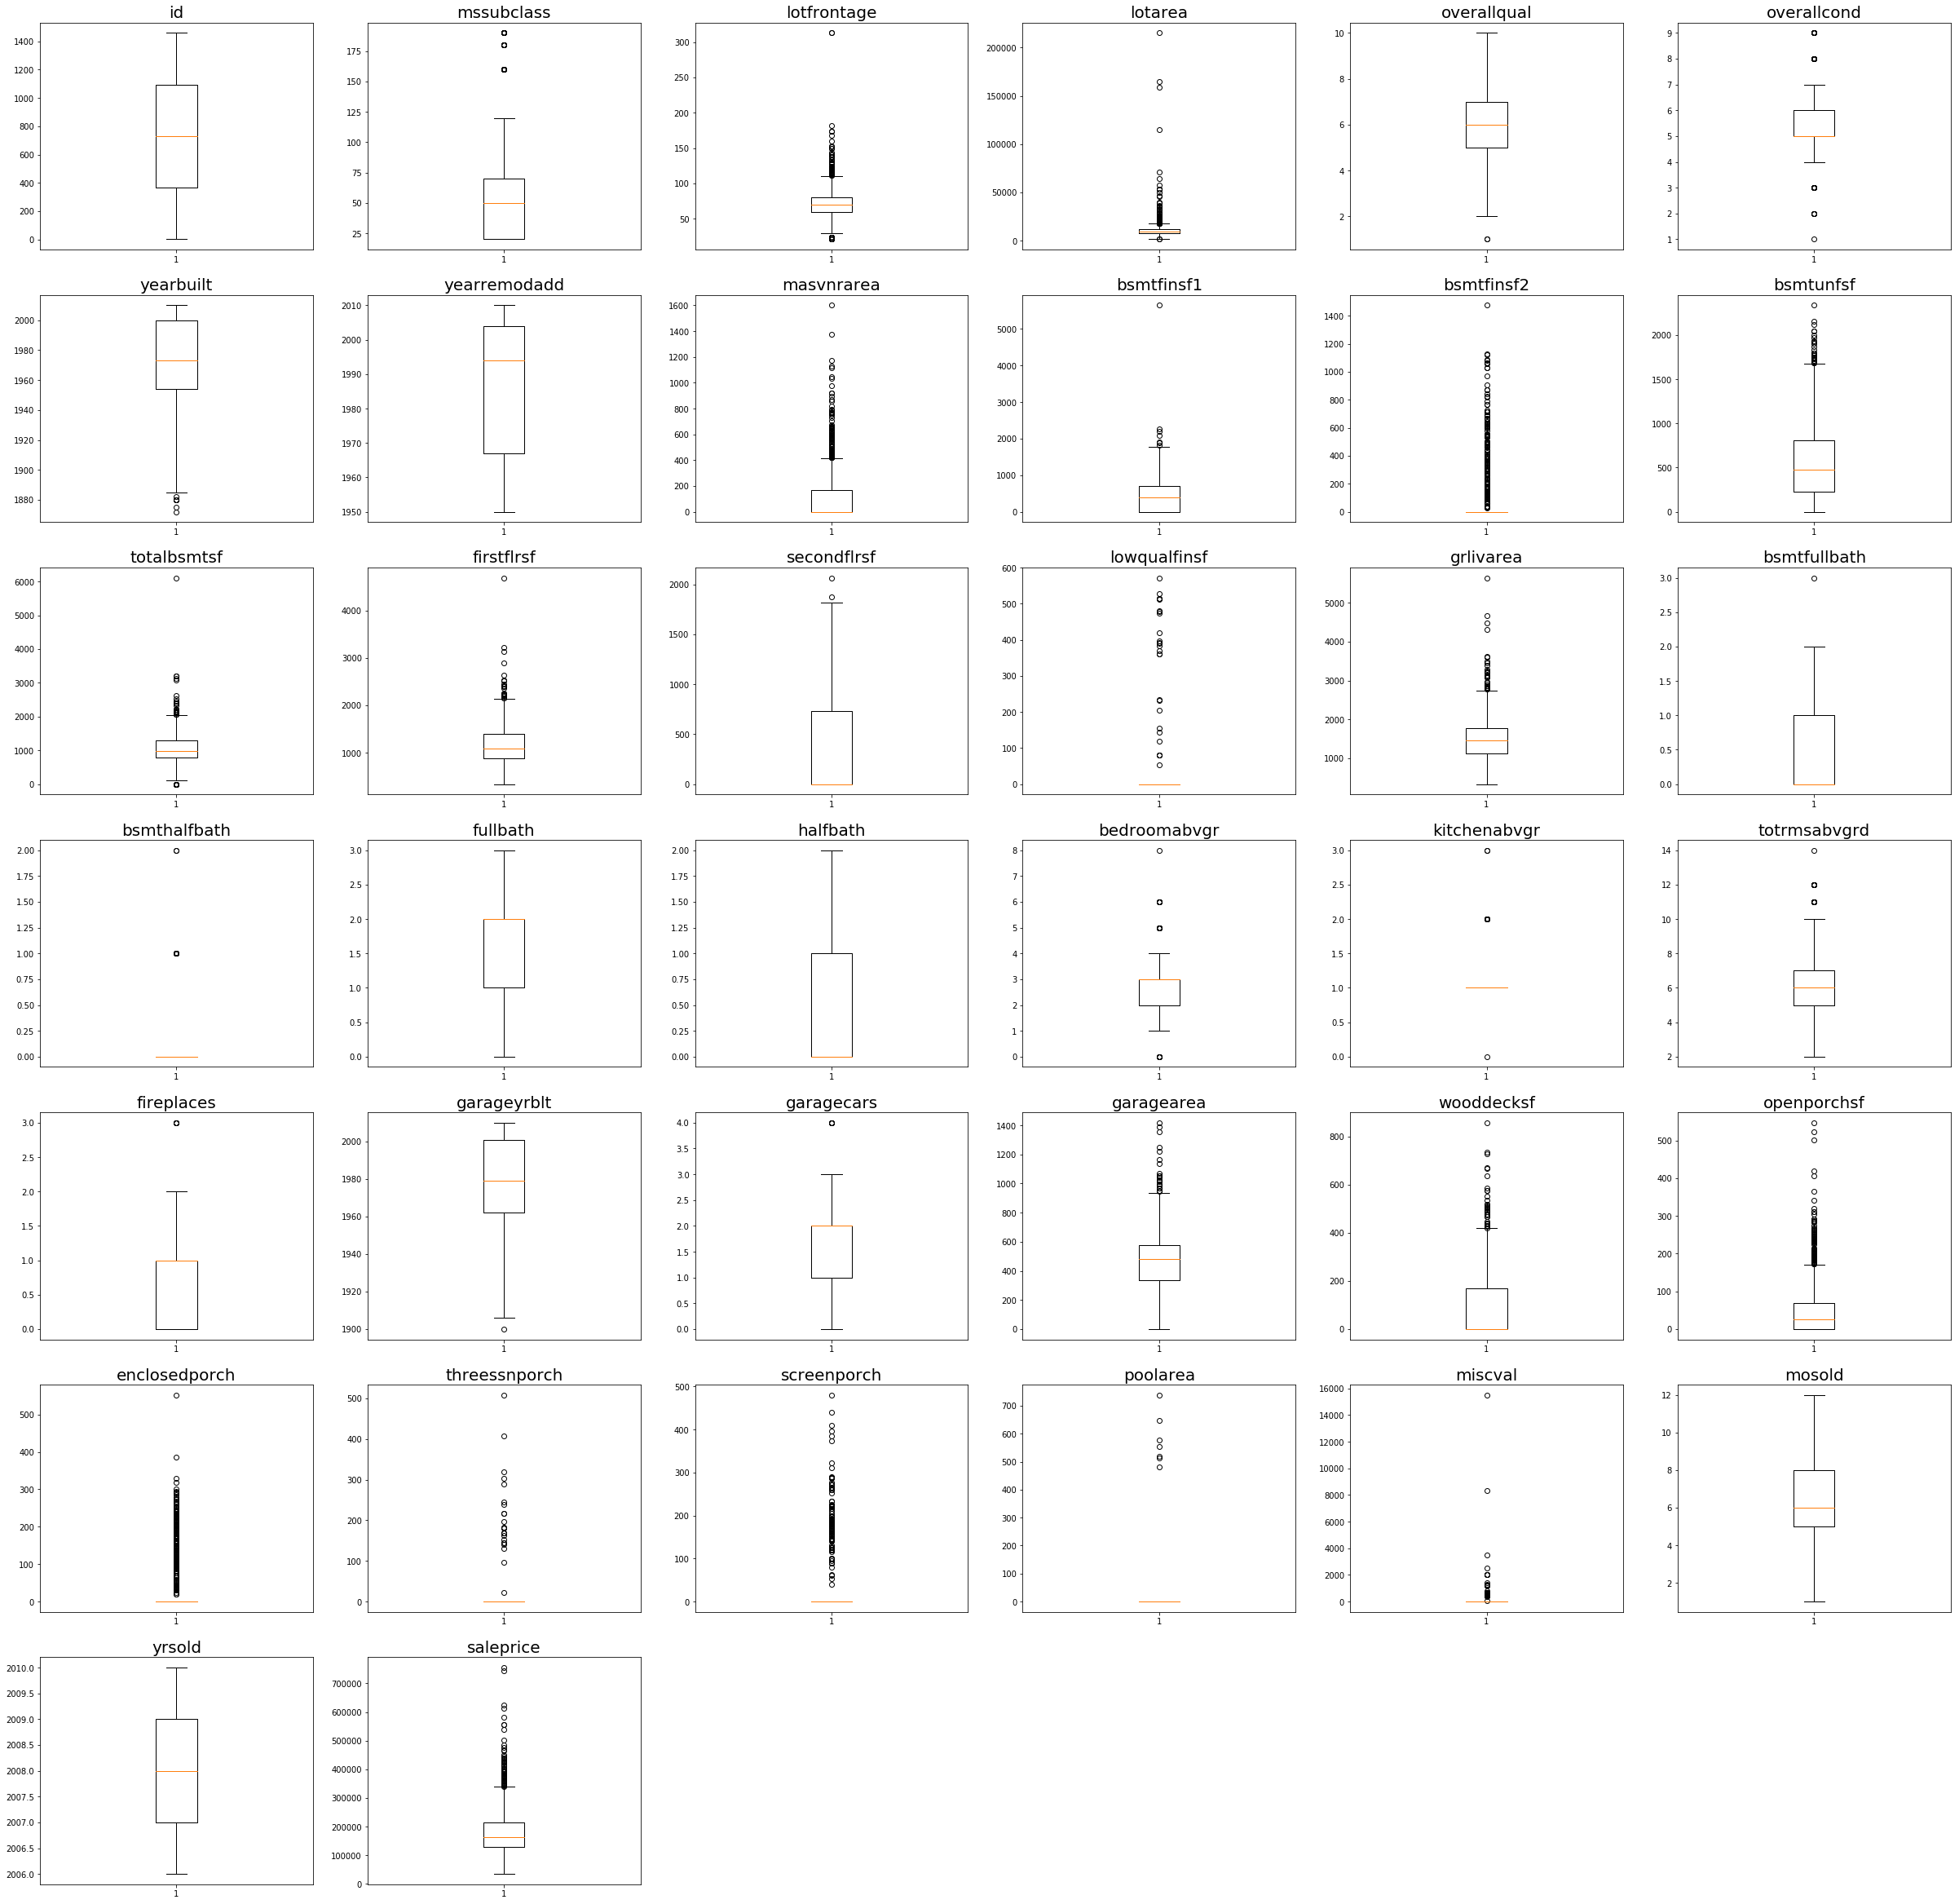

In [12]:
housing_int_df = housing_df.select_dtypes(include=['float64','int'])

def get_boxplot(df):
    ceil = math.ceil(math.sqrt(len(df.columns)))
    flr = math.floor(math.sqrt(len(df.columns)))
    plt.figure(figsize=(ceil*flr,ceil*flr))
    i = 1
    #print(df.columns)
    for column in df.columns: 
        plt.subplot(ceil,flr,i)
        plt.boxplot(df[column])
        plt.title(df[column].name,fontsize=20)
        i+=1
plt.tight_layout()
plt.show() 

get_boxplot(housing_int_df)

- We see the presence of many outliers in the numerical data, a quick function deletes all data point further than 3 standard deviations away from the respective mean.

In [23]:
df_int = housing_df.select_dtypes(include=['float64','int'])
    
for col in df_int:
    housing_df = housing_df[((housing_df[col] - housing_df[col].mean()) / housing_df[col].std()).abs() < 3] 


In [24]:
len(housing_df)

753

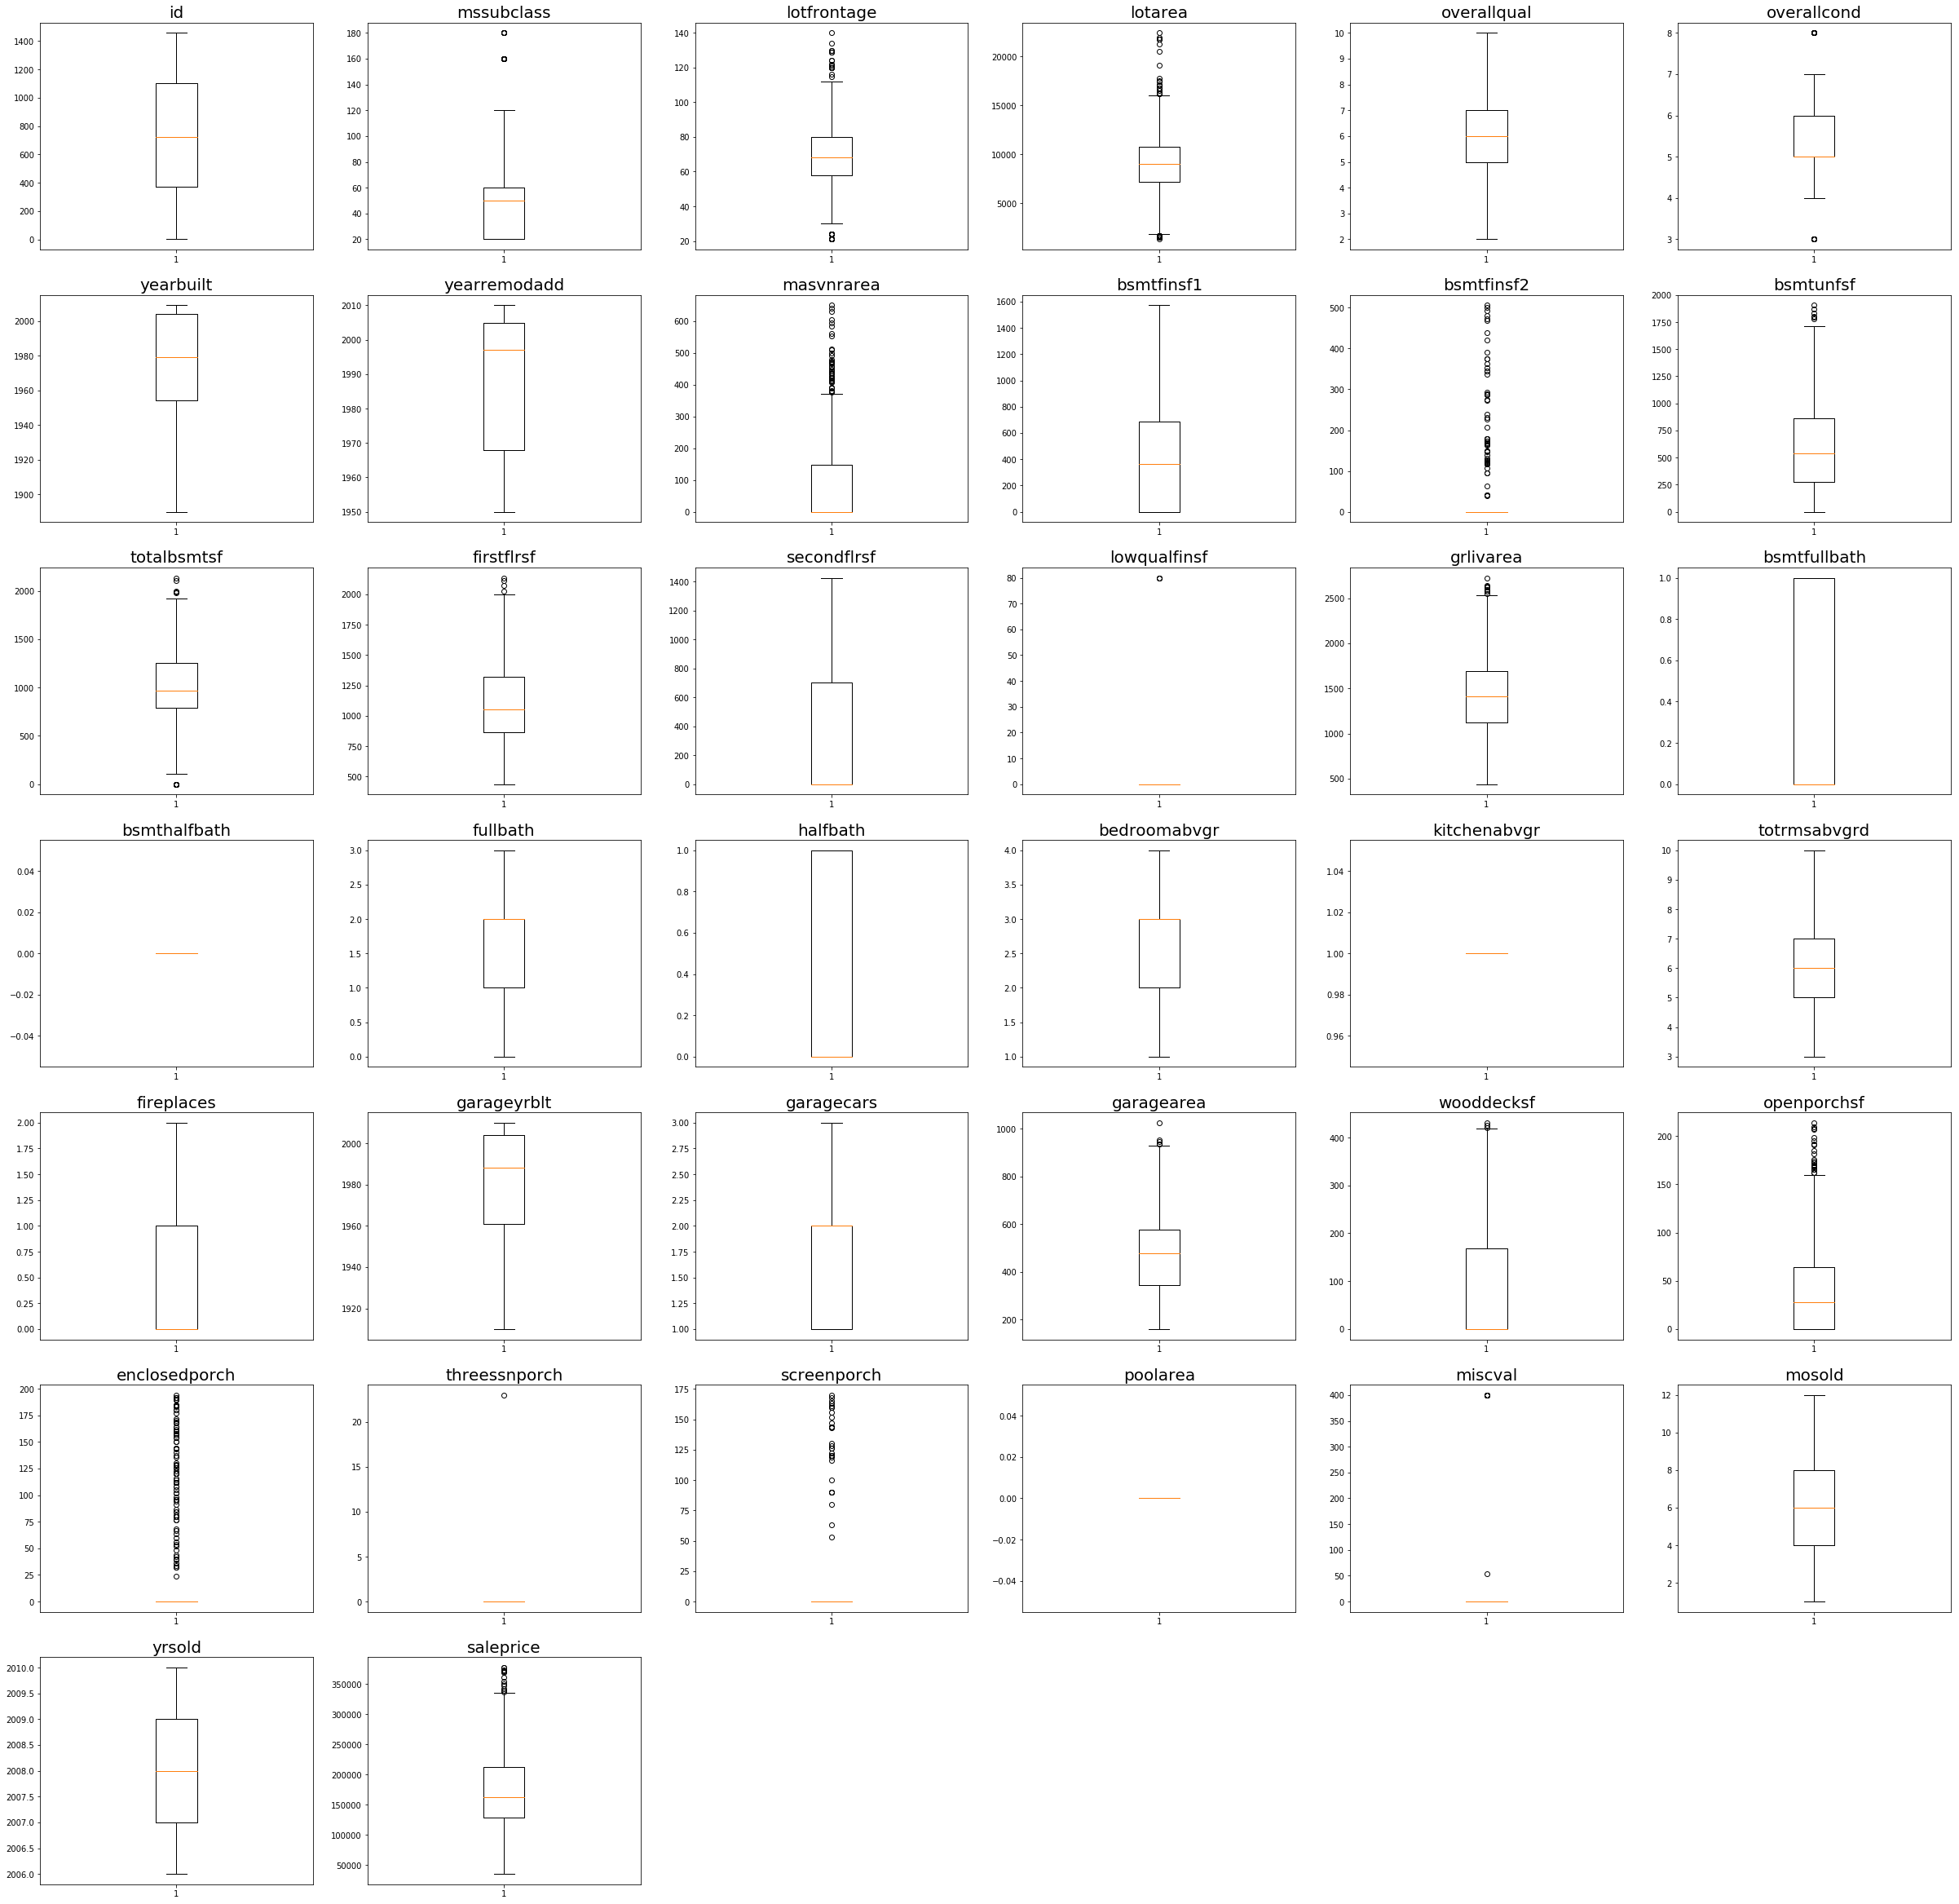

In [25]:
get_boxplot(housing_df.select_dtypes(include=['float64','int']))

## Analysis and Feature Selection

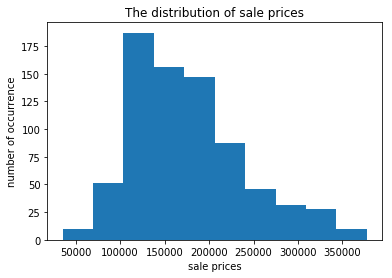

In [26]:
plt.hist(housing_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()


-  Our target variable saleprice seems to be distributed non-normally.

In [27]:
np.abs(housing_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.821117
grlivarea        0.752777
garagecars       0.697740
garagearea       0.666102
fullbath         0.663096
totalbsmtsf      0.642236
yearbuilt        0.635358
firstflrsf       0.608416
garageyrblt      0.591824
totrmsabvgrd     0.581055
yearremodadd     0.580650
openporchsf      0.440906
masvnrarea       0.437962
fireplaces       0.429165
lotfrontage      0.400485
lotarea          0.400316
bsmtfinsf1       0.356055
wooddecksf       0.352482
secondflrsf      0.270200
bedroomabvgr     0.251980
bsmtfullbath     0.250808
bsmtunfsf        0.226844
halfbath         0.214228
enclosedporch    0.204201
overallcond      0.177305
bsmtfinsf2       0.111540
mosold           0.105596
mssubclass       0.058041
miscval          0.045486
lowqualfinsf     0.027633
yrsold           0.017462
screenporch      0.011408
threessnporch    0.003114
bsmthalfbath          NaN
kitchenabvgr          NaN
poolarea              NaN
Name: saleprice, dtype: float64

- Taking the correlations of the features with our target variable irrespective of their signs by taking absolute values.

- To understand the relationships between our target variable and features, plot each feature against the target variable. 
- In the charts below, we show the average sale prices with respect to the each categories of a feature.

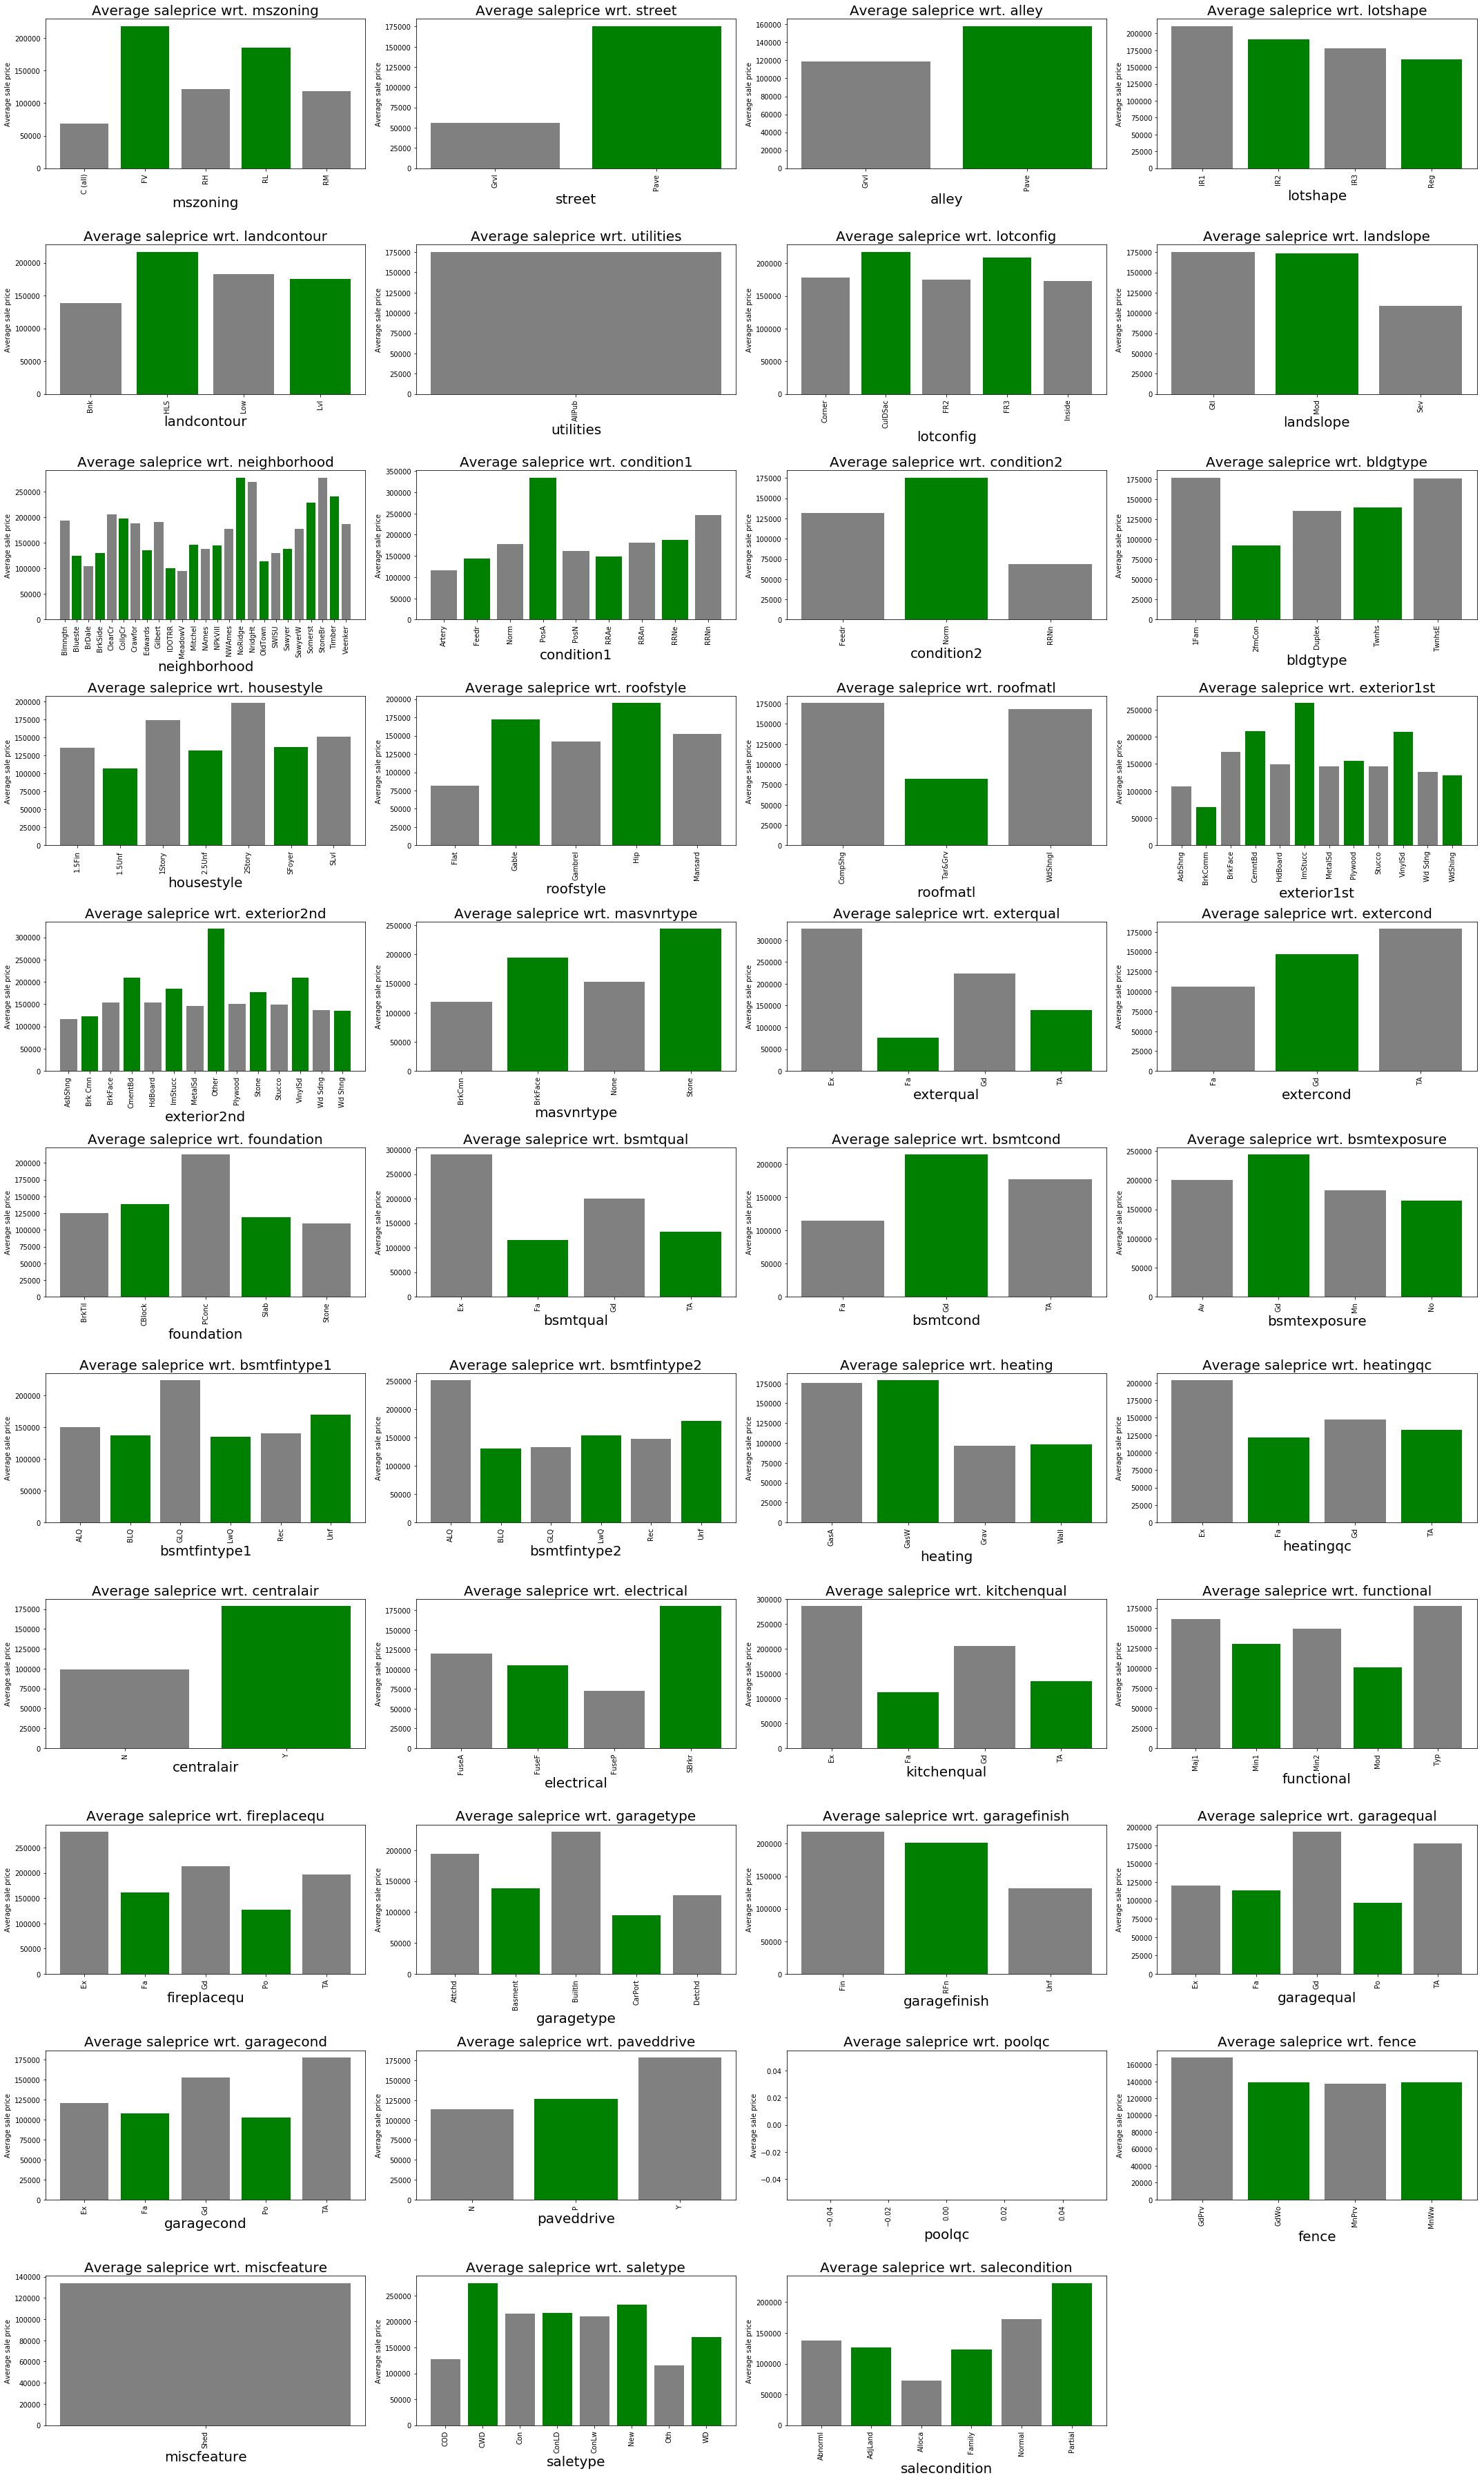

In [28]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(housing_df.groupby(column)["saleprice"].mean().index, housing_df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column),fontsize=20)
    plt.ylabel("Average sale price")
    plt.xlabel(column,fontsize=20)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [33]:
housing_reg_df =  housing_df.copy()
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.centralair, 
                                                            prefix="centralair", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.mszoning, 
                                                            prefix="mszoning", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.bldgtype, 
                                                            prefix="bldgtype", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.exterqual, 
                                                            prefix="exterqual", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.bsmtqual, 
                                                            prefix="bsmtqual", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.salecondition, 
                                                            prefix="salecondition", drop_first=True)], axis=1)

In [40]:
housing_reg_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,exterqual_Gd,exterqual_TA,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_TA,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,1,0,0,1,0,0,0,0,1,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,1,0,0,1,0,0,0,0,1,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,1,0,0,1,0,0,0,0,1,0
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,1,0,0,0,0,0,0,0,1,0
10,11,20,RL,70.0,11200,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,1,0,0,0,1,0


In [39]:
dummy_column_names = list(pd.get_dummies(housing_reg_df.centralair, prefix="centralair", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(housing_reg_df.mszoning, prefix="mszoning", 
                drop_first=True).columns)+ list(pd.get_dummies(housing_reg_df.bldgtype, prefix="bldgtype", 
                drop_first=True).columns)+ list(pd.get_dummies(housing_reg_df.exterqual, prefix="exterqual", 
                drop_first=True).columns)+ list(pd.get_dummies(housing_reg_df.bsmtqual, prefix="bsmtqual", 
                drop_first=True).columns)+ list(pd.get_dummies(housing_reg_df.salecondition, prefix="salecondition", 
                drop_first=True).columns)

- As our model, we choose the 6 numerical variables that are most correlated with the sale price. 
- We also add 6 non-numerical features to our model as their values exhibit some variance with respect to the average sale price. In order to use them in our model, we needed to convert them to dummy variables.

## Regression Model

In [41]:
X = housing_reg_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'garagearea', 'firstflrsf'] 
                   + dummy_column_names]
Y = housing_reg_df.saleprice

In [44]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     206.2
Date:                Wed, 19 Jun 2019   Prob (F-statistic):          1.64e-314
Time:                        16:15:23   Log-Likelihood:                -8600.2
No. Observations:                 753   AIC:                         1.725e+04
Df Residuals:                     726   BIC:                         1.738e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1202.0245   1.45e+04      0.083      0.934   -2.72e+04    2.96e+04
overallqual            1.078e+04   1204.377      8.948      0.000    8412.560    1.31e+04
grlivarea                53.8629      2.814     19.144      0.000      48.339      59.387
garagecars             2174.1068   2789.767      0.779      0.436   -3302.866    7651.080
totalbsmtsf              47.1548      5.094      9.257      0.000      37.154      57.156
garagearea               40.0006      9.072      4.409      0.000      22.190      57.811
firstflrsf              -16.2112      5.510     -2.942      0.003     -27.029      -5.394
centralair_Y           1.642e+04   4420.716      3.714      0.000    7741.318    2.51e+04
mszoning_FV            2.942e+04   1.09e+04      2.699      0.007    8020.770    5.08e+04
mszoning_RH            2.066e+04   1.31e+04      1.576      0.116   -5084.741    4.64e+04
mszoning_RL            2.145e+04   1.03e+04      2.081      0.038    1211.594    4.17e+04
mszoning_RM            1.332e+04   1.04e+04      1.283      0.200   -7060.140    3.37e+04
bldgtype_2fmCon       -1155.9850   3.14e+04     -0.037      0.971   -6.27e+04    6.04e+04
bldgtype_Duplex       -8128.3608   1.31e+04     -0.618      0.536   -3.39e+04    1.77e+04
bldgtype_Twnhs        -1.821e+04   4362.301     -4.175      0.000   -2.68e+04   -9650.272
bldgtype_TwnhsE       -8764.6001   3255.854     -2.692      0.007   -1.52e+04   -2372.588
exterqual_Fa          -4.142e+04   2.15e+04     -1.927      0.054   -8.36e+04     786.987
exterqual_Gd          -3.079e+04   7204.378     -4.274      0.000   -4.49e+04   -1.66e+04
exterqual_TA          -4.004e+04   7805.223     -5.130      0.000   -5.54e+04   -2.47e+04
bsmtqual_Fa           -3.664e+04   6632.553     -5.524      0.000   -4.97e+04   -2.36e+04
bsmtqual_Gd           -2.851e+04   3453.689     -8.254      0.000   -3.53e+04   -2.17e+04
bsmtqual_TA           -3.776e+04   4081.658     -9.250      0.000   -4.58e+04   -2.97e+04
salecondition_AdjLand  3.101e+04   2.31e+04      1.339      0.181   -1.44e+04    7.65e+04
salecondition_Alloca  -1.684e+04   1.97e+04     -0.855      0.393   -5.55e+04    2.18e+04
salecondition_Family  -8112.4391   8247.408     -0.984      0.326   -2.43e+04    8079.177
salecondition_Normal   7816.4084   3468.433      2.254      0.025    1007.052    1.46e+04
salecondition_Partial  1.129e+04   4410.681      2.560      0.011    2630.680    1.99e+04
==============================================================================
Omnibus:                       85.511   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              550.428
Skew:                          -0.246   Prob(JB):                    2.99e-120
Kurtosis:                       7.159   Cond. No.                  

- Adjusted R-squared equal to .876
- model may be improved by multicolinearity analysis.